In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from SHIPS_ML_model_funcs import calc_AUPD, calculate_PD_curves
from SHIPS_plotting import plot_roc_curve, plot_precision_recall_vs_threshold,add_model_results,make_performance_diagram_background
from SHIPS_plotting import plot_CSI_vs_bias, plot_PD_curves_compare_models 
import matplotlib.colors

In [2]:
load_dir = '~/SHIPS/SHIPS_clean/Model_Results/COMPARE_SAMPLING/LOGISTIC/Figures/'

In [3]:
sampling_strat = ['random_oversampling','SMOTE05','SMOTE075','SMOTE1','nearmiss_1','random_undersampling',
                 'combo_random_over_random_under']#,'nearmiss_1',
                # 'SMOTE_r05']
solver = ['lbfgs']#,'saga']
RI_thresh = 30
scoring = 'f1_weighted'
N_samples = 15
stand_str = 'STANDARDIZED'
mask_type = 'SIMPLE_MASK'
yr_start = 2005
yr_end = 2019

load_suffix = '_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_type}_{stand_str}_RI_thresh_{RI_thresh}_'\
'{N_samples}_samples_{scoring}.csv'.format(yr_start=yr_start,yr_end=yr_end,mask_type=mask_type,stand_str=stand_str,
                                          RI_thresh=RI_thresh,N_samples=N_samples,scoring=scoring)

In [4]:
prec_vs_rec_ALL = pd.DataFrame()
y_pred_y_true_ALL = pd.DataFrame()
cm_ALL = pd.DataFrame()
roc_ALL = pd.DataFrame()
for i_solv in solver:
    for i_samp in sampling_strat:
        model_str = i_solv +' '+ i_samp
        i_pvr = load_dir+'Prec_vs_recall_{solver}_{sampling}'.format(solver=i_solv,sampling=i_samp)+load_suffix
        pvr = pd.read_csv(i_pvr)
        pvr = pvr.drop(columns='Model')
        pvr['Solver'] = i_solv
        pvr['Model'] = model_str
        #
        ypred = pd.read_csv(load_dir+'PREDICTED_Y_vals_{solver}_{sampling}'.format(solver=i_solv,sampling=i_samp)+load_suffix)
        ypred['Model'] = model_str
        ypred['Solver'] = i_solv
        #
        icm = pd.read_csv(load_dir+'Conf_Matrix_{solver}_{sampling}'.format(solver=i_solv,sampling=i_samp)+load_suffix)
        icm['Model'] = model_str
        icm['Solver'] = i_solv
        #
        iroc = pd.read_csv(load_dir+'ROC_AUC_vals_{solver}_{sampling}'.format(solver=i_solv,
                                                        sampling=i_samp)+load_suffix)
        iroc['Model'] = model_str
        iroc['Solver'] = i_solv
        #
        prec_vs_rec_ALL = prec_vs_rec_ALL.append(pvr)
        y_pred_y_true_ALL = y_pred_y_true_ALL.append(ypred)
        cm_ALL = cm_ALL.append(icm)
        roc_ALL = roc_ALL.append(iroc)
        

Add class weighting example

In [5]:
weight_dir = '~/SHIPS/SHIPS_clean/Model_Results/LOGISTIC/'
load_suffix_weight = '_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_type}_{stand_str}_RI_thresh_{RI_thresh}weights_'\
'default_wts_{N_samples}_samples_{scoring}.csv'.format(yr_start=yr_start,yr_end=yr_end,mask_type=mask_type,stand_str=stand_str,
                                          RI_thresh=RI_thresh,N_samples=N_samples,scoring=scoring)
#
#prec_vs_rec_wt = pd.DataFrame()
#y_pred_y_true_wt = pd.DataFrame()
#cm_wt = pd.DataFrame()
#roc_wt = pd.DataFrame()
model_str = i_solv
i_pvr = weight_dir+'Prec_vs_recall_{solver}'.format(solver=i_solv)+load_suffix_weight
pvr = pd.read_csv(i_pvr)
pvr = pvr.drop(columns='Model')
pvr['Solver'] = i_solv
pvr['Model'] = 'Class Weights'
#
ypred = pd.read_csv(weight_dir+'PREDICTED_Y_vals_{solver}'.format(solver=i_solv)+load_suffix_weight)
ypred['Model'] = 'Class Weights'
ypred['Solver'] = i_solv
#
icm = pd.read_csv(weight_dir+'Conf_Matrix_{solver}'.format(solver=i_solv)+load_suffix_weight)
icm['Model'] = 'Class Weights'
icm['Solver'] = i_solv
#
iroc = pd.read_csv(weight_dir+'ROC_AUC_vals_{solver}'.format(solver=i_solv)+load_suffix_weight)
iroc['Model'] = 'Class Weights'
iroc['Solver'] = i_solv
#
prec_vs_rec_ALL = prec_vs_rec_ALL.append(pvr)
y_pred_y_true_ALL = y_pred_y_true_ALL.append(ypred)
cm_ALL = cm_ALL.append(icm)
roc_ALL = roc_ALL.append(iroc)


In [6]:
basin_ALL = roc_ALL['BASIN'].unique().tolist()
roc_ALL['Model'].unique().tolist()

['lbfgs random_oversampling',
 'lbfgs SMOTE05',
 'lbfgs SMOTE075',
 'lbfgs SMOTE1',
 'lbfgs nearmiss_1',
 'lbfgs random_undersampling',
 'lbfgs combo_random_over_random_under',
 'Class Weights']

In [7]:
def add_model_resultsx(ax,CM,cat_sel='RI'):
    # Inputs:
    # ax: axes for corresponding figure
    # CM: dataframe containing confusion matrix 
    # Category selected: RI or not RI? Default is RI
    # 
    # Get the means, minima, and maxima for each model / basin
    CM_rs = CM.reset_index().set_index(['Category Names','BASIN','Model','Fold'])
    CM_mean = CM_rs.median(level=(0,1,2))
    CM_min = CM.groupby(['Category Names','BASIN','Model']).quantile(0.025)
    CM_max = CM.groupby(['Category Names','BASIN','Model']).quantile(0.975)
    CM_ALL_sel = CM_mean.loc[cat_sel]
    # Get error bar bounds
    y_lower = -1*CM_min.loc[cat_sel]['POD'].reset_index().sort_values('BASIN',ignore_index=True) + CM_ALL_sel['POD'].reset_index().sort_values('BASIN',ignore_index=True)
    y_upper = CM_max.loc[cat_sel]['POD'].reset_index().sort_values('BASIN',ignore_index=True) + -1*CM_ALL_sel['POD'].reset_index().sort_values('BASIN',ignore_index=True)
    #cm_ALL_yerr = [y_lower.values,y_upper.values]
    cm_ALL_yerr = [y_lower['POD'],y_upper['POD']]
    #
    x_lower = -1*CM_min.loc[cat_sel]['SR'].reset_index().sort_values('BASIN',ignore_index=True) + CM_ALL_sel['SR'].reset_index().sort_values('BASIN',ignore_index=True)
    x_upper = CM_max.loc[cat_sel]['SR'].reset_index().sort_values('BASIN',ignore_index=True) + -1*CM_ALL_sel['SR'].reset_index().sort_values('BASIN',ignore_index=True)

    cm_ALL_xerr = [x_lower['SR'],x_upper['SR']]
    # Make a colormap for each basin
    colors_list = ['hot pink','navy','goldenrod','green','violet']
    pal_sel = sns.color_palette(sns.xkcd_palette(colors_list),5)
    # Plot error bars in both x and y
    ax.errorbar(CM_ALL_sel.reset_index().sort_values('BASIN',ignore_index=True)['SR'],
                CM_ALL_sel.reset_index().sort_values('BASIN',ignore_index=True)['POD'],
                yerr=cm_ALL_yerr,xerr=cm_ALL_xerr,
           linestyle='none',linewidth=2,color='xkcd:slate grey',zorder=9)
    sns.scatterplot(data=CM_ALL_sel.reset_index().sort_values('BASIN',ignore_index=True),
                  x='SR',y='POD',hue='BASIN',style='Model',ax=ax,
                   palette=sns.set_palette(pal_sel),s=300,alpha=0.8,zorder=10)
    ax.legend(fontsize=14)

In [8]:
cm_ALL['Model'].unique()

array(['lbfgs random_oversampling', 'lbfgs SMOTE05', 'lbfgs SMOTE075',
       'lbfgs SMOTE1', 'lbfgs nearmiss_1', 'lbfgs random_undersampling',
       'lbfgs combo_random_over_random_under', 'Class Weights'],
      dtype=object)

/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(


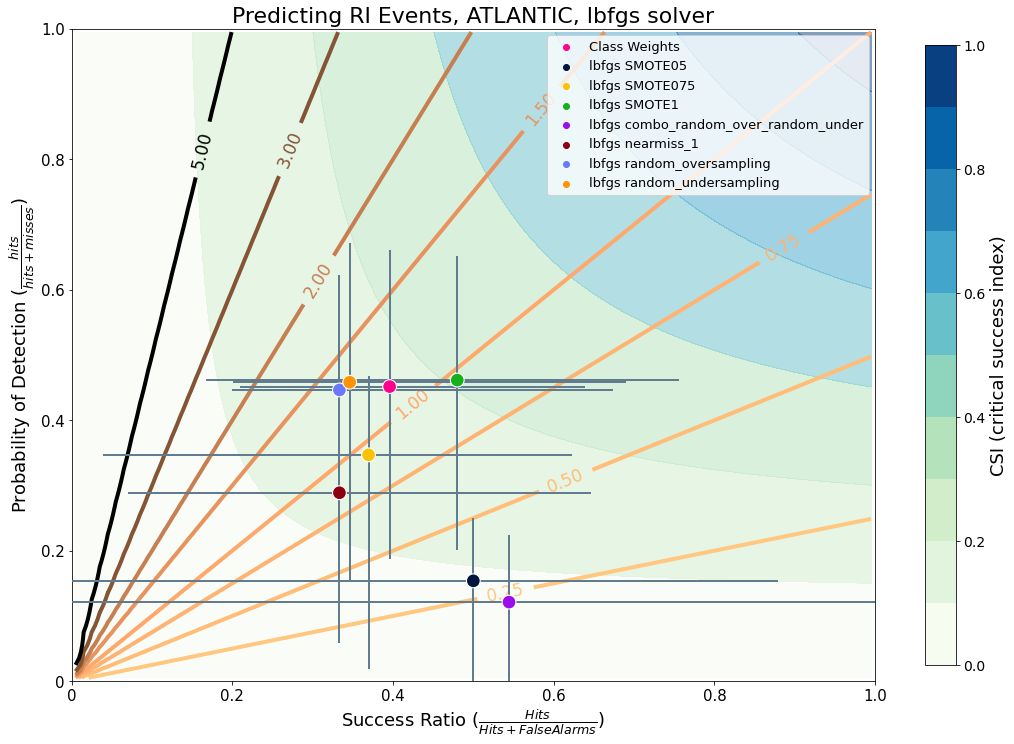

In [22]:
fig5,ax5 = plt.subplots(1,1,figsize=(18,12))
make_performance_diagram_background(ax5)
solv_sel = 'lbfgs'
basin_sel = 'ATLANTIC'
cm_sel = cm_ALL.set_index(['Solver']).xs(solv_sel)
cm_sel = cm_sel.set_index(['BASIN']).xs(basin_sel)
cm_sel = cm_sel[cm_sel['Model'].isin(['lbfgs SMOTE075','lbfgs random_oversampling','lbfgs random_undersampling',
                                     'lbfgs SMOTE05','lbfgs SMOTE1','lbfgs nearmiss_1',
                                      'lbfgs combo_random_over_random_under','Class Weights'])]
#add_model_resultsx(ax5,cm_sel)
cm_median = cm_sel.groupby(['Category Names','BASIN','Model']).median()
cm_min = cm_sel.groupby(['Category Names','BASIN','Model']).quantile(0.025)
cm_max = cm_sel.groupby(['Category Names','BASIN','Model']).quantile(0.975)
x_lower = cm_min.xs('RI')['SR'].reset_index().sort_values('BASIN',ignore_index=True)
x_upper = cm_max.xs('RI')['SR'].reset_index().sort_values('BASIN',ignore_index=True)
x_err = [cm_median.xs('RI')['SR'] - x_lower.set_index(['BASIN','Model'])['SR'],
         x_upper.set_index(['BASIN','Model'])['SR']-cm_median.xs('RI')['SR']]
#
y_lower = cm_min.xs('RI')['POD'].reset_index().sort_values('BASIN',ignore_index=True)
y_upper = cm_max.xs('RI')['POD'].reset_index().sort_values('BASIN',ignore_index=True)
y_err = [cm_median.xs('RI')['POD'] - y_lower.set_index(['Model'])['POD'],
         y_upper.set_index(['Model'])['POD']-cm_median.xs('RI')['POD']]
#x_err_plt = x_err.reset_index().sort_values('BASIN',ignore_index=True)['SR']
colors_list = ['hot pink','navy','goldenrod','green','violet','crimson','cornflower','tangerine']
pal_sel = sns.color_palette(sns.xkcd_palette(colors_list),8)
#
ax5.set_xlim([0,1])
ax5.set_ylim([0,1])
ax5.errorbar(cm_median.xs('RI').reset_index().sort_values('BASIN',ignore_index=True)['SR'],
            cm_median.xs('RI').reset_index().sort_values('BASIN',ignore_index=True)['POD'],
            xerr=x_err,yerr=y_err,color='xkcd:blue gray',
            linestyle='none',linewidth=2,zorder=9)
sns.scatterplot(data=cm_median.xs('RI').reset_index(),x='SR',y='POD',hue='Model',palette=pal_sel,s=190,zorder=10)
ax5.legend(fontsize=13)
ax5.set_title('Predicting RI Events, {basin_sel}, {solv_sel} solver'.format(basin_sel=basin_sel,solv_sel=solv_sel),
             fontsize=22)
fig5.savefig('Figures/COMPARE_SAMPLING_performance_diagram_{basin_sel}_{solv_sel}.png'.format(basin_sel=basin_sel,
                            solv_sel=solv_sel),format='png',dpi=250,bbox_inches='tight')

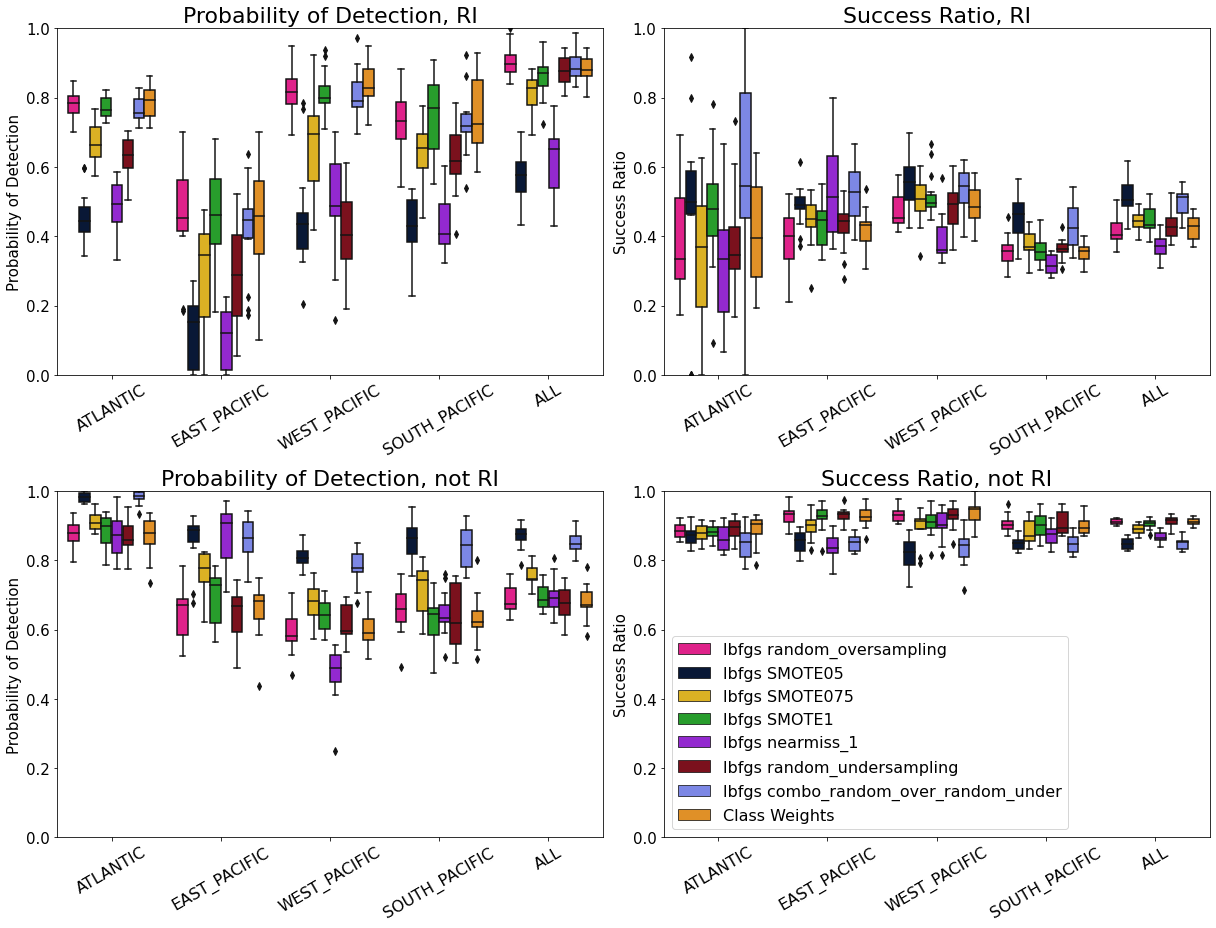

In [10]:
fig6,((ax6a,ax6b),(ax6c,ax6d)) = plt.subplots(2,2,figsize=(17,13))
cm_plt = cm_ALL.set_index(['Category Names'])
cm_plt_total = cm_plt.reset_index().groupby(['Category Names','BASIN','Model','Fold']).mean()
#cm_plt_norm = 
sns.boxplot(data=cm_plt_total.xs('RI').reset_index(),x='BASIN',y='POD',hue='Model',ax=ax6a,palette=sns.set_palette(pal_sel))
ax6a.set_ylabel('Probability of Detection',fontsize=15)
ax6a.get_legend().remove()
#ax6a.legend(fontsize=12)
ax6a.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6a.set_title('Probability of Detection, RI',fontsize=22)
ax6a.set_xlabel(None)
ax6a.set_ylim([0,1])
ax6a.tick_params(axis='y',labelsize=15)
#
sns.boxplot(data=cm_plt.xs('RI').reset_index(),x='BASIN',y='SR',hue='Model',ax=ax6b)
ax6b.set_ylabel('Success Ratio',fontsize=15)
#ax6b.legend(fontsize=12)
ax6b.get_legend().remove()
ax6b.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6b.set_title('Success Ratio, RI',fontsize=22)
ax6b.set_xlabel(None)
ax6b.set_ylim([0,1])
ax6b.tick_params(axis='y',labelsize=15)
#
sns.boxplot(data=cm_plt.xs('not RI').reset_index(),x='BASIN',y='POD',hue='Model',ax=ax6c)
ax6c.set_ylabel('Probability of Detection',fontsize=15)
#ax6c.legend(fontsize=12)
ax6c.get_legend().remove()
ax6c.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6c.set_title('Probability of Detection, not RI',fontsize=22)
ax6c.set_xlabel(None)
ax6c.tick_params(axis='y',labelsize=15)
ax6c.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').reset_index(),x='BASIN',y='SR',hue='Model',ax=ax6d)
ax6d.set_ylabel('Success Ratio',fontsize=15)
ax6d.legend(fontsize=16)
ax6d.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6d.set_title('Success Ratio, not RI',fontsize=22)
ax6d.set_xlabel(None)
ax6d.tick_params(axis='y',labelsize=15)
ax6d.set_ylim([0,1])
#
fig6.tight_layout()

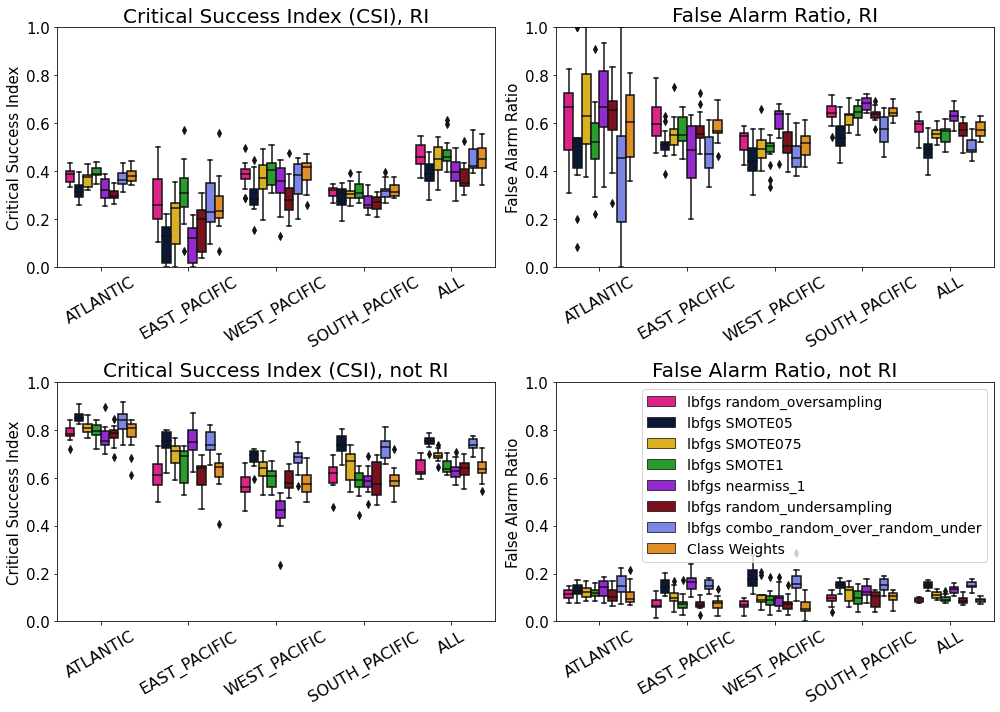

In [11]:
fig6,((ax6a,ax6b),(ax6c,ax6d)) = plt.subplots(2,2,figsize=(14,10))
cm_plt = cm_ALL.set_index(['Category Names'])
cm_plt_total = cm_plt.reset_index().groupby(['Category Names','BASIN','Model','Fold']).mean()
#cm_plt_norm = 
sns.boxplot(data=cm_plt_total.xs('RI').reset_index(),x='BASIN',y='Threat',hue='Model',ax=ax6a,
           palette=sns.set_palette(pal_sel))
ax6a.set_ylabel('Critical Success Index',fontsize=15)
ax6a.get_legend().remove()
ax6a.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6a.set_title('Critical Success Index (CSI), RI',fontsize=20)
ax6a.set_xlabel(None)
ax6a.tick_params(axis='y',labelsize=15)
ax6a.set_ylim([0,1])
#ax6a.set_ylim([0,150])
#
sns.boxplot(data=cm_plt.xs('RI').reset_index(),x='BASIN',y='FAR',hue='Model',ax=ax6b)
ax6b.set_ylabel('False Alarm Ratio',fontsize=15)
ax6b.get_legend().remove()
ax6b.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6b.set_title('False Alarm Ratio, RI',fontsize=20)
ax6b.set_xlabel(None)
ax6b.tick_params(axis='y',labelsize=15)
ax6b.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').reset_index(),x='BASIN',y='Threat',hue='Model',ax=ax6c)
ax6c.set_ylabel('Critical Success Index',fontsize=15)
ax6c.get_legend().remove()
ax6c.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6c.set_title('Critical Success Index (CSI), not RI',fontsize=20)
ax6c.set_xlabel(None)
ax6c.tick_params(axis='y',labelsize=15)
ax6c.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').reset_index(),x='BASIN',y='FAR',hue='Model',ax=ax6d)
ax6d.set_ylabel('False Alarm Ratio',fontsize=15)
ax6d.legend(fontsize=14)
ax6d.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6d.set_title('False Alarm Ratio, not RI',fontsize=20)
ax6d.set_xlabel(None)
ax6d.tick_params(axis='y', labelsize= 15)
ax6d.set_ylim([0,1])
#
fig6.tight_layout()

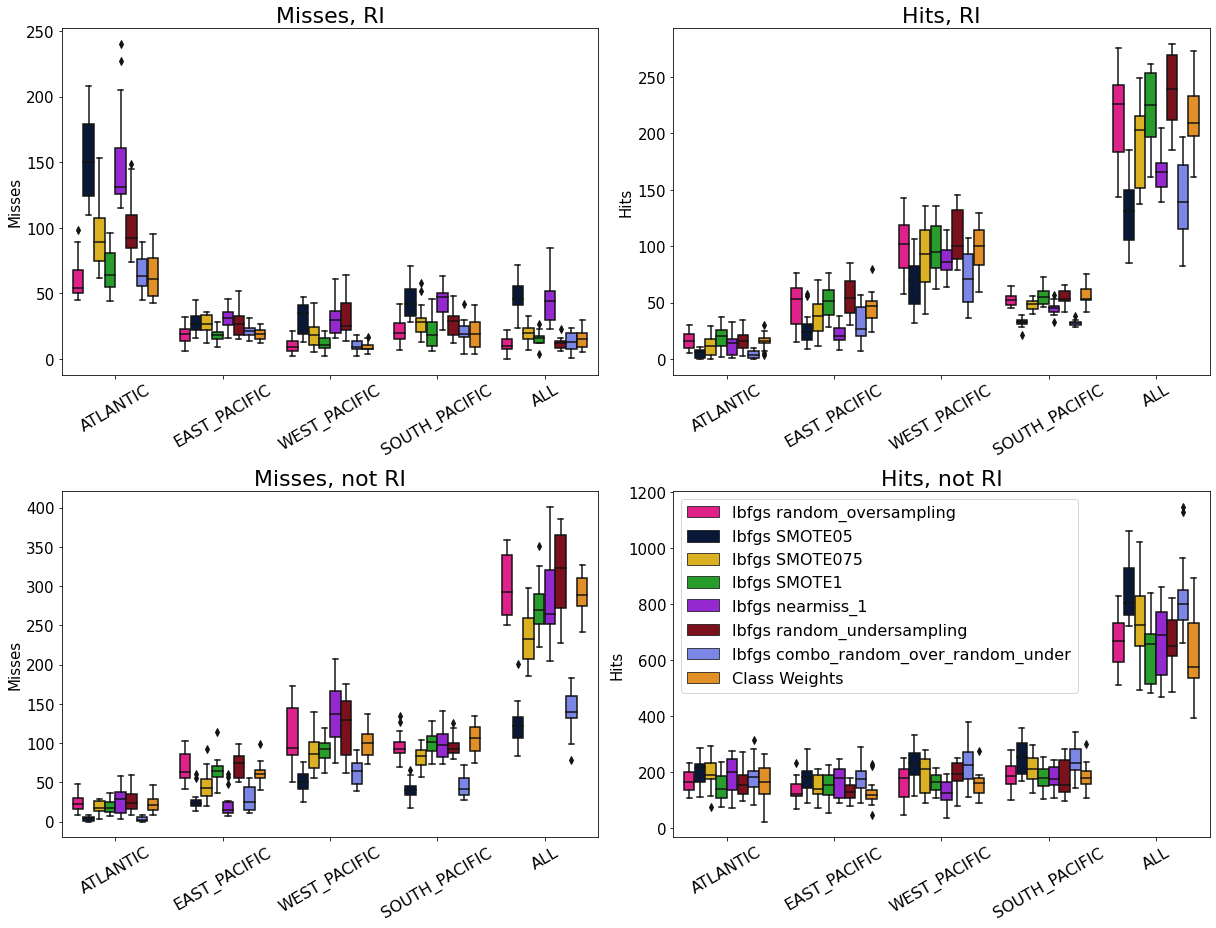

In [12]:
fig6,((ax6a,ax6b),(ax6c,ax6d)) = plt.subplots(2,2,figsize=(17,13))
cm_plt = cm_ALL.set_index(['Category Names'])
cm_plt_total = cm_plt.reset_index().groupby(['Category Names','BASIN','Model','Fold']).mean()
#cm_plt_norm = 
sns.boxplot(data=cm_plt_total.xs('RI').reset_index(),x='BASIN',y='Misses',hue='Model',ax=ax6a,palette=sns.set_palette(pal_sel))
ax6a.set_ylabel('Misses',fontsize=15)
ax6a.get_legend().remove()
#ax6a.legend(fontsize=12)
ax6a.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6a.set_title('Misses, RI',fontsize=22)
ax6a.set_xlabel(None)
# ax6a.set_ylim([0,1])
ax6a.tick_params(axis='y',labelsize=15)
#
sns.boxplot(data=cm_plt.xs('RI').reset_index(),x='BASIN',y='Hits',hue='Model',ax=ax6b)
ax6b.set_ylabel('Hits',fontsize=15)
#ax6b.legend(fontsize=12)
ax6b.get_legend().remove()
ax6b.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6b.set_title('Hits, RI',fontsize=22)
ax6b.set_xlabel(None)
# ax6b.set_ylim([0,1])
ax6b.tick_params(axis='y',labelsize=15)
#
sns.boxplot(data=cm_plt.xs('not RI').reset_index(),x='BASIN',y='Misses',hue='Model',ax=ax6c)
ax6c.set_ylabel('Misses',fontsize=15)
#ax6c.legend(fontsize=12)
ax6c.get_legend().remove()
ax6c.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6c.set_title('Misses, not RI',fontsize=22)
ax6c.set_xlabel(None)
ax6c.tick_params(axis='y',labelsize=15)
# ax6c.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').reset_index(),x='BASIN',y='Hits',hue='Model',ax=ax6d)
ax6d.set_ylabel('Hits',fontsize=15)
ax6d.legend(fontsize=16)
ax6d.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6d.set_title('Hits, not RI',fontsize=22)
ax6d.set_xlabel(None)
ax6d.tick_params(axis='y',labelsize=15)
# ax6d.set_ylim([0,1])
#
fig6.tight_layout()

ROC curve

Text(0.5, 1.0, 'Identifying RI versus non-RI, ALL, f1_weighted')

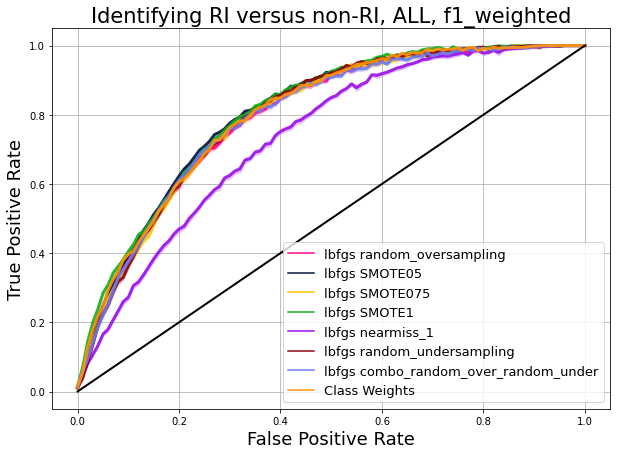

In [25]:
basin_sel = 'ALL'
fig2,ax2 = plt.subplots(1,1,figsize=(10,7))
roc_res = roc_ALL.set_index(['Solver']).xs(solv_sel)
roc_vals_plt = roc_res.set_index(['BASIN']).xs(basin_sel).reset_index()
roc_vals_plt[['FPR round','TPR round']] = roc_vals_plt[['False Positive Rate','True Positive Rate']].round(2)
#roc_min = roc_vals_plt['AUC ROC Score'].min()
#roc_max = roc_vals_plt['AUC ROC Score'].max()

sns.lineplot(data=roc_vals_plt,x='FPR round',y='TPR round',hue='Model',ax=ax2,
            alpha=0.9,linewidth=3)
ax2.plot([0,1],[0,1],color='k',linewidth=2)
#
auc_scores = roc_vals_plt.groupby(['Model'])['AUC ROC Score'].mean()
#for i in np.arange(0,len(auc_scores)):
 #   ax2.axhline(auc_scores.iloc[i],color=sns.color_palette()[i],linewidth=2)
#ax2.axhline(auc_scores.loc['Random Forest'],color=sns.color_palette()[0],linewidth=2)
#ax2.axhline(auc_scores.loc['lbfgs'],color=sns.color_palette()[1],linewidth=2)
#ax2.axhline(auc_scores.loc['saga'],color=sns.color_palette()[2],linewidth=2)
#ax2.axhspan(roc_min,roc_max,color='xkcd:gray',alpha=0.25,label='AUC Score')
ax2.set_xlabel('False Positive Rate',fontsize=18)
ax2.set_ylabel('True Positive Rate',fontsize=18)
#roc_vals_mean = roc_vals_plt.groupby(roc_vals_plt['False Positive Rate'].round(2))[['True Positive Rate',
#                                'AUC Thresholds']].mean().reset_index()
#roc_vals_mean.plot(x='False Positive Rate',y='True Positive Rate',ax=ax2,color='xkcd:tangerine',linewidth=5,
#                  label='ROC curve')
ax2.legend(fontsize=13)
ax2.grid()
ax2.set_title('Identifying RI versus non-RI, {basin_sel}, {scoring}'.format(basin_sel=basin_sel,scoring=scoring),fontsize=21)


Performance diagram curves

In [14]:
def plot_PD_curves_compare_models(p_vs_r,ax,basin_sel,CSI_metric='median'):
    pr_smoothed = p_vs_r.groupby(['BASIN','Model','Fold','Thresh Round']).mean().xs(basin_sel)
    #pr_mean = pr_smoothed.groupby(['Model','Thresh Round']).mean().reset_index()
    # Get curve for median AUPD
    max_CSI_ind = p_vs_r.groupby(['BASIN','Model','Fold'])[['CSI','Bias']].agg({'CSI':'max'})#.xs(basin_sel)
    colors = ['xkcd:magenta','xkcd:navy','xkcd:goldenrod','xkcd:green','xkcd:purple','xkcd:crimson','xkcd:cornflower',
             'xkcd:tangerine']
    if CSI_metric == 'median':
        aupd_med = max_CSI_ind.xs(basin_sel).median(level=0)
        models_list = aupd_med.index.unique().tolist()
        for i in np.arange(0,len(models_list)):
            i_model = models_list[i]
           # print(i_model)
            CSI_fold = max_CSI_ind.xs((basin_sel,i_model)).loc[max_CSI_ind.xs((basin_sel,
                                                   i_model))['CSI']==aupd_med.loc[i_model]['CSI']]
            pr_smoothed.xs((i_model,CSI_fold.index[0])).plot(x='Success Ratio',y='POD',color=colors[i],linewidth=4,ax=ax,
                                                linestyle='-',label=i_model)
        
    elif CSI_metric == 'min':
        min_fold = max_CSI_ind.xs(basin_sel).min(level=0)
        models_list = min_fold.index.unique().tolist()
        for i in np.arange(0,len(models_list)):
            i_model = models_list[i]
            print(i_model)
            CSI_fold = max_CSI_ind.xs((basin_sel,i_model)).loc[max_CSI_ind.xs((basin_sel,
                                                   i_model))['CSI']==min_fold.loc[i_model]['CSI']]
            pr_smoothed.xs((i_model,CSI_fold.index[0])).plot(x='Success Ratio',y='POD',color=colors[i],linewidth=4,ax=ax,
                                                linestyle='-',label=i_model)
    elif CSI_metric == 'max':
        min_fold = max_CSI_ind.xs(basin_sel).max(level=0)
        models_list = min_fold.index.unique().tolist()
        for i in np.arange(0,len(models_list)):
            i_model = models_list[i]
            print(i_model)
            CSI_fold = max_CSI_ind.xs((basin_sel,i_model)).loc[max_CSI_ind.xs((basin_sel,
                                                   i_model))['CSI']==min_fold.loc[i_model]['CSI']]
            pr_smoothed.xs((i_model,CSI_fold.index[0])).plot(x='Success Ratio',y='POD',color=colors[i],linewidth=4,ax=ax,
                                                linestyle='-',label=i_model)
    #sns.lineplot(data=pr_mean.sort_values('POD'),x='Success Ratio',y='POD',hue='Fold',
     #           sort=False,color='xkcd:purple',ax=ax,linewidth=4,legend=False)
    ax.set_xlim([0,1])
    ax.legend(fontsize=14)
    ax.set_ylim([0,1])

/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(


Class Weights
lbfgs SMOTE05
lbfgs SMOTE075
lbfgs SMOTE1
lbfgs combo_random_over_random_under
lbfgs nearmiss_1
lbfgs random_oversampling
lbfgs random_undersampling


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(


Class Weights
lbfgs SMOTE05
lbfgs SMOTE075
lbfgs SMOTE1
lbfgs combo_random_over_random_under
lbfgs nearmiss_1
lbfgs random_oversampling
lbfgs random_undersampling


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(


Class Weights
lbfgs SMOTE05
lbfgs SMOTE075
lbfgs SMOTE1
lbfgs combo_random_over_random_under
lbfgs nearmiss_1
lbfgs random_oversampling
lbfgs random_undersampling


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(


Class Weights
lbfgs SMOTE05
lbfgs SMOTE075
lbfgs SMOTE1
lbfgs combo_random_over_random_under
lbfgs nearmiss_1
lbfgs random_oversampling
lbfgs random_undersampling


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(


Class Weights
lbfgs SMOTE05
lbfgs SMOTE075
lbfgs SMOTE1
lbfgs combo_random_over_random_under
lbfgs nearmiss_1
lbfgs random_oversampling
lbfgs random_undersampling


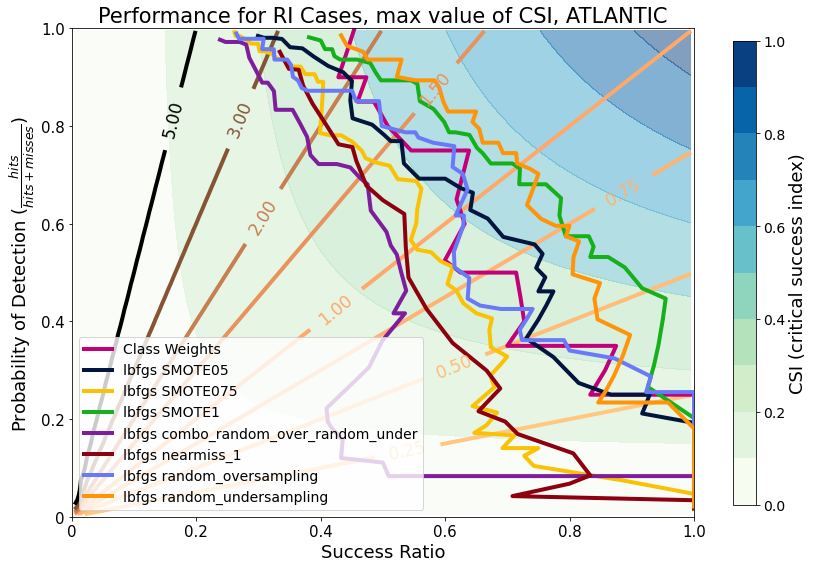

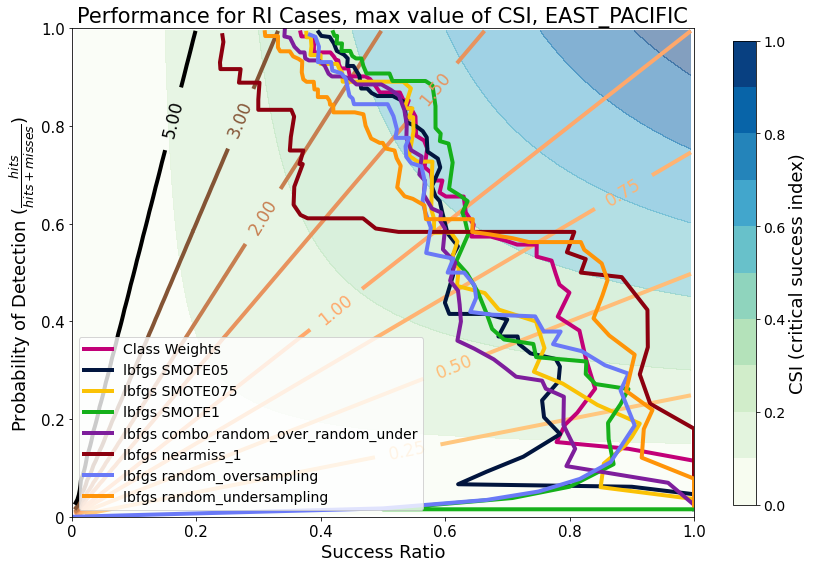

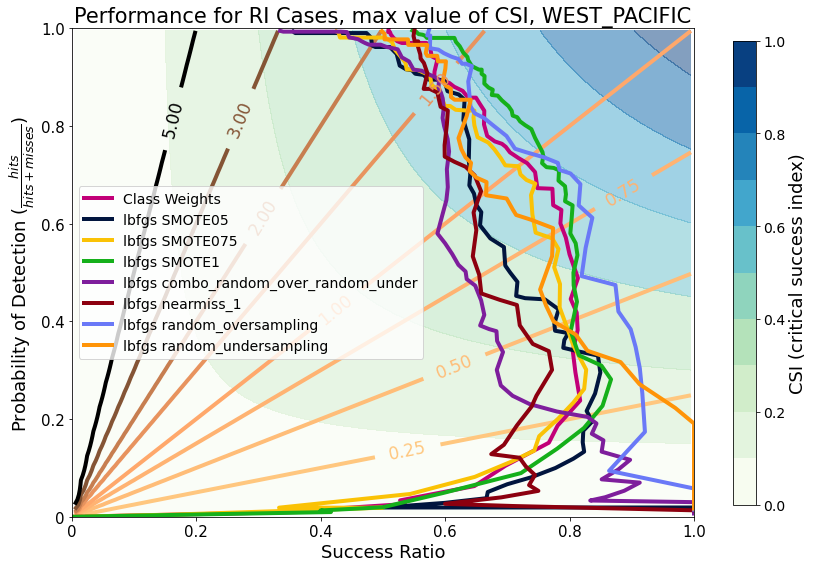

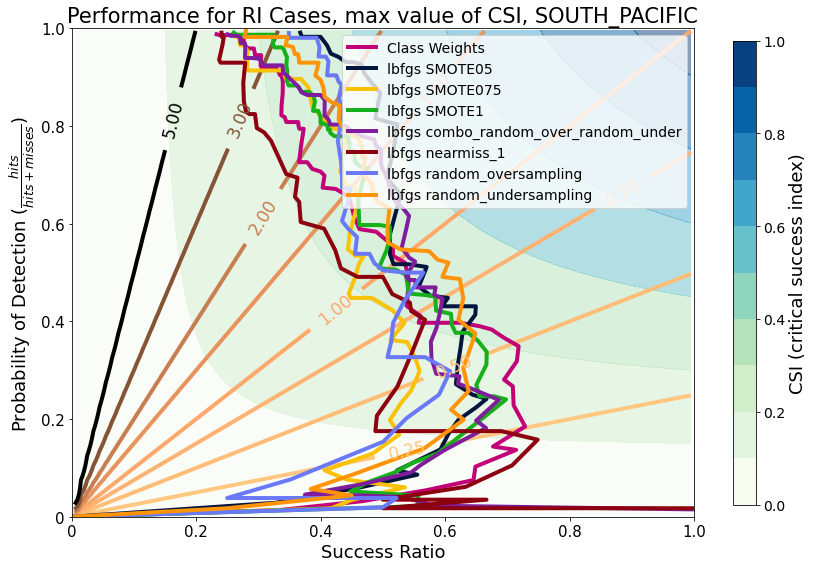

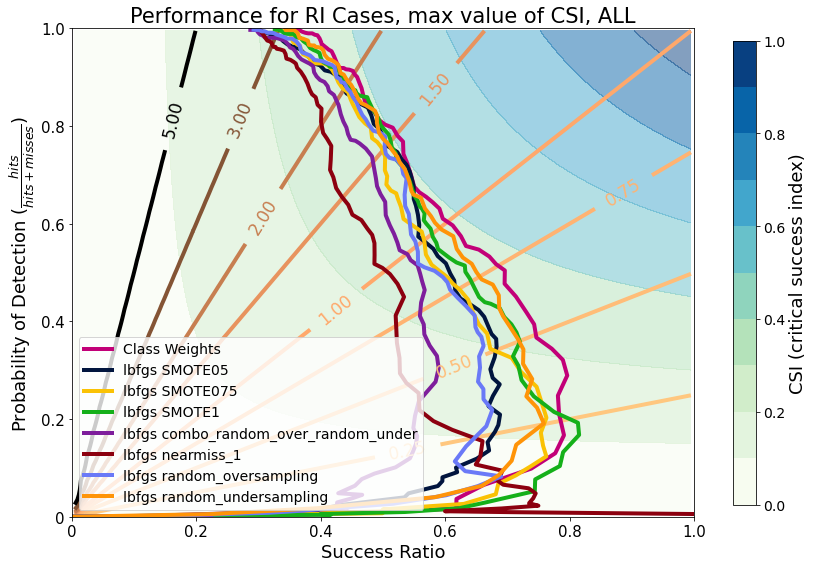

In [15]:
prec_vs_rec = prec_vs_rec_ALL.set_index(['Solver']).xs(solv_sel).reset_index()

pd_curves = calculate_PD_curves(prec_vs_rec)
metric_plt = 'max'
for basin_sel in basin_ALL:
    fig23,ax23 = plt.subplots(1,1,figsize=(12,8))
    make_performance_diagram_background(ax23)
    #basin_sel = 'ALL'
    #
    plot_PD_curves_compare_models(prec_vs_rec,ax23,basin_sel,metric_plt)
    ax23.set_title('Performance for RI Cases, {metric_plt} value of CSI, {basin_sel}'.format(metric_plt=metric_plt,
                                                                            basin_sel=basin_sel),fontsize=21)
    fig23.tight_layout()

In [16]:
aupd_scores = calc_AUPD(prec_vs_rec)
aupd_scores = aupd_scores.reset_index().rename(columns={0:'AUPD Score'})

Text(0.5, 1.0, 'Maximum CSI Value, RI Cases')

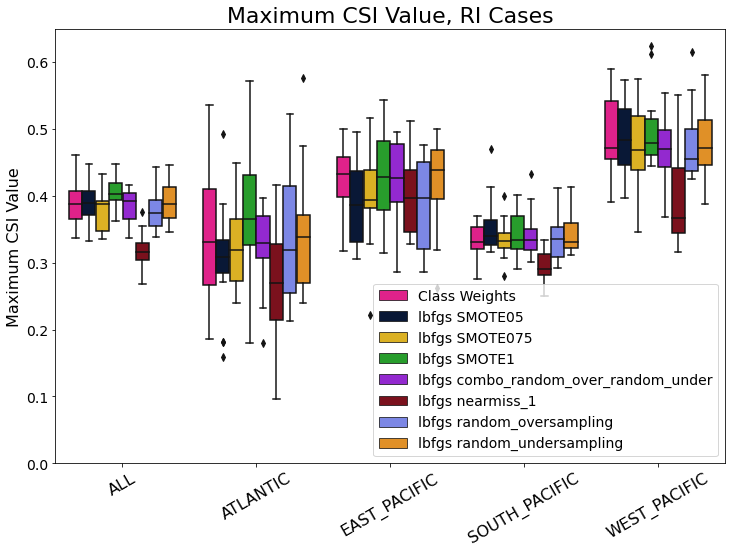

In [17]:
max_CSI_ind = prec_vs_rec.groupby(['BASIN','Model','Fold'])[['CSI','Bias']].agg({'CSI':'max'}).reset_index()

fig16,ax16 = plt.subplots(1,1,figsize=(12,8))
is_swarm = False
if is_swarm:
    sns.swarmplot(data=max_CSI_ind,x='BASIN',y='CSI',hue='Model',ax=ax16,s=12)
    fname_save = 'Figures/max_CSI_values_SWARM.png'
else:
    sns.boxplot(data=max_CSI_ind,x='BASIN',y='CSI',hue='Model',ax=ax16)
    fname_save = 'Figures/max_CSI_values_BOX.png'
ax16.set_xlabel(None)
ax16.set_xticklabels(aupd_scores.reset_index()['BASIN'].unique().tolist(),fontsize=16,rotation=30)
ax16.set_ylabel('Maximum CSI Value',fontsize=16)
ax16.tick_params(axis='y',labelsize=14)
ax16.legend(fontsize=14)
ax16.set_ylim([0,0.65])
ax16.set_title('Maximum CSI Value, RI Cases',fontsize=22)

Text(0.5, 1.0, 'Bias at Maximum CSI for RI Cases')

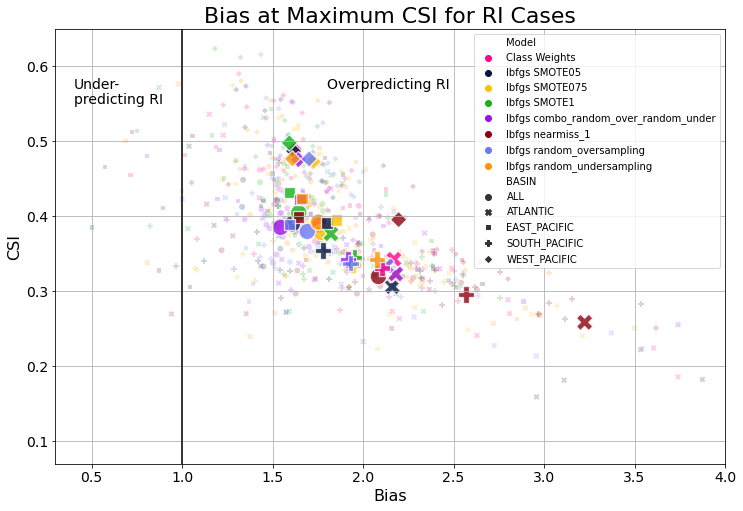

In [18]:
fig20,ax20 = plt.subplots(1,1,figsize=(12,8))
ax20.axvline(1,color='xkcd:charcoal',linewidth=2)
#colors_list = ['hot pink','navy','goldenrod','green','violet']
#pal_sel = sns.color_palette(sns.xkcd_palette(colors_list),5)
b_c_max = prec_vs_rec.sort_values(['CSI'], ascending=[False]).groupby(['BASIN','Model','Fold']).first()
# Plot
sns.scatterplot(data=b_c_max.reset_index(),x='Bias',y='CSI',hue='Model',style='BASIN',ax=ax20,
                alpha=0.2,legend=False,palette=pal_sel)
# Get mean bias for max CSI of each basin
sns.scatterplot(data=b_c_max.mean(level=(0,1)).reset_index(),
            x='Bias',y='CSI',hue='Model',style='BASIN',s=270,ax=ax20,alpha=0.8,palette=pal_sel)
# Formatting
ax20.legend(fontsize=10)
ax20.tick_params(axis='y',labelsize=14)
ax20.tick_params(axis='x',labelsize=14)
ax20.set_ylabel('CSI',fontsize=16)
ax20.set_xlabel('Bias',fontsize=16)
ax20.grid()
ax20.set_xlim([0.3,4])
ax20.text(0.4,0.57,'Under-',fontsize=14)
ax20.text(0.4,0.55,'predicting RI',fontsize=14)
ax20.text(1.8,0.57,'Overpredicting RI',fontsize=14)
ax20.set_title('Bias at Maximum CSI for RI Cases',fontsize=22)

In [19]:
b_c_max

Solver  Unnamed: 0 CLASS  \
BASIN        Model                      Fold                            
ALL          Class Weights              0     lbfgs         591    RI   
                                        1     lbfgs         827    RI   
                                        2     lbfgs         606    RI   
                                        3     lbfgs         881    RI   
                                        4     lbfgs         708    RI   
...                                             ...         ...   ...   
WEST_PACIFIC lbfgs random_undersampling 10    lbfgs         245    RI   
                                        11    lbfgs          77    RI   
                                        12    lbfgs         256    RI   
                                        13    lbfgs          76    RI   
                                        14    lbfgs          60    RI   

                                              Cutoff Threshold    Recall  \
BASIN        Model                      Fold                               
ALL          Class Weights              0             0.535967  0.731132   
                                        1             0.481288  0.762803   
                                        2             0.517596  0.793103   
                                        3             0.499986  0.703704   
                                        4             0.506886  0.775000   
...                                                        ...       ...   
WEST_PACIFIC lbfgs random_undersampling 10            0.679511  0.744898   
                                        11            0.625281  0.817308   
                                        12            0.637628  0.857143   
                                        13            0.632383  0.802326   
                                        14            0.633793  0.853933   

                                              Precision  Thresholds        F1  \
BASIN        Model                      Fold                                    
ALL          Class Weights              0      0.383663    0.535967  0.503247   
                                        1      0.452800    0.481288  0.568273   
                                        2      0.470348    0.517596  0.590501   
                                        3      0.463415    0.499986  0.558824   
                                        4      0.392405    0.506886  0.521008   
...                                                 ...         ...       ...   
WEST_PACIFIC lbfgs random_undersampling 10     0.467949    0.679511  0.574803   
                                        11     0.578231    0.625281  0.677291   
                                        12     0.478723    0.637628  0.614334   
                                        13     0.589744    0.632383  0.679803   
                                        14     0.644068    0.633793  0.734300   

                                                     Years Out       POD  \
BASIN        Model                      Fold                               
ALL          Class Weights              0     [2010 2006 2008]  0.731132   
                                        1     [2018 2017 2015]  0.762803   
                                        2     [2006 2009 2016]  0.793103   
                                        3     [2008 2011 2018]  0.703704   
                                        4     [2006 2016 2011]  0.775000   
...                                                        ...       ...   
WEST_PACIFIC lbfgs random_undersampling 10    [2017 2012 2005]  0.744898   
                                        11    [2010 2018 2011]  0.817308   
                                        12    [2005 2012 2006]  0.857143   
                                        13    [2013 2011 2016]  0.802326   
                                        14    [2013 2008 2016]  0.853933   

                                                   FAR  Success

Text(0.5, 1.0, 'Area Under Performance Diagram, RI Cases')

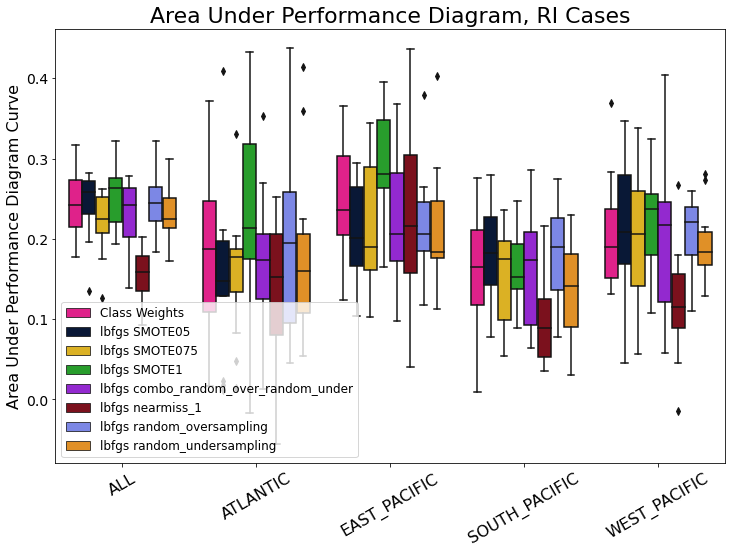

In [20]:
fig15,ax15 = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(data=aupd_scores.reset_index(),x='BASIN',y='AUPD Score',hue='Model',ax=ax15)
ax15.set_xlabel(None)
ax15.set_xticklabels(aupd_scores.reset_index()['BASIN'].unique().tolist(),fontsize=16,rotation=30)
ax15.set_ylabel('Area Under Performance Diagram Curve',fontsize=16)
ax15.tick_params(axis='y',labelsize=14)
ax15.legend(fontsize=12)
ax15.set_title('Area Under Performance Diagram, RI Cases',fontsize=22)